In [1]:
!pip install wfdb


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries
import wfdb
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


In [3]:
# Load the ECG record
record = wfdb.rdrecord('mit-bih-arrhythmia-database-1.0.0/202')
signals = record.p_signal
sampling_rate = record.fs

In [4]:

# Bandpass filter design
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [5]:
# Filter parameters
lowcut = 0.5  # Low cutoff frequency in Hz
highcut = 40.0  # High cutoff frequency in Hz

# Extract the first 10 seconds of each signal
duration = 10  # seconds
num_samples = duration * sampling_rate
signal1 = signals[:num_samples, 0]  # First channel
signal2 = signals[:num_samples, 1]  # Second channel

In [6]:
# Apply bandpass filter
filtered_signal1 = bandpass_filter(signal1, lowcut, highcut, sampling_rate)
filtered_signal2 = bandpass_filter(signal2, lowcut, highcut, sampling_rate)

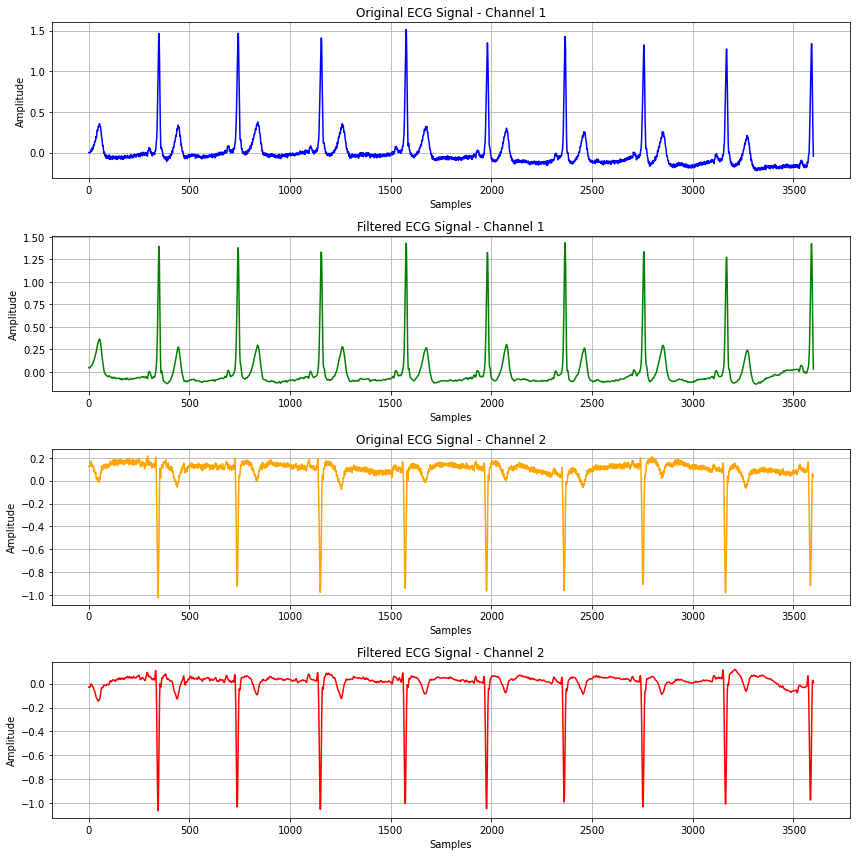

In [7]:
# Plot the original and filtered signals
plt.figure(figsize=(12, 12))

# Original Signal 1
plt.subplot(4, 1, 1)
plt.plot(signal1, color='blue')
plt.title('Original ECG Signal - Channel 1')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid()

# Filtered Signal 1
plt.subplot(4, 1, 2)
plt.plot(filtered_signal1, color='green')
plt.title('Filtered ECG Signal - Channel 1')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid()

# Original Signal 2
plt.subplot(4, 1, 3)
plt.plot(signal2, color='orange')
plt.title('Original ECG Signal - Channel 2')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid()

# Filtered Signal 2
plt.subplot(4, 1, 4)
plt.plot(filtered_signal2, color='red')
plt.title('Filtered ECG Signal - Channel 2')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid()

plt.tight_layout()
plt.show()

In [8]:
import numpy as np

def segment_signal(signal, window_size, overlap):
    segments = []
    step_size = window_size - overlap
    for start in range(0, len(signal) - window_size + 1, step_size):
        segments.append(signal[start:start + window_size])
    return np.array(segments)

# Parameters for segmentation
window_size = 2500  # Number of samples (e.g., 10 seconds at 250 Hz)
overlap = 500       # Number of overlapping samples

# Segment the filtered signal
segmented_signal1 = segment_signal(filtered_signal1, window_size, overlap)
segmented_signal2 = segment_signal(filtered_signal2, window_size, overlap)


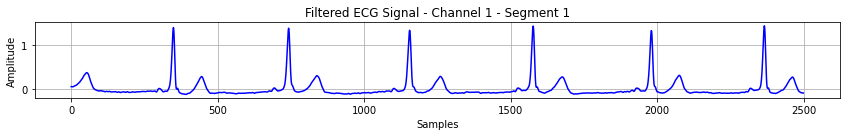

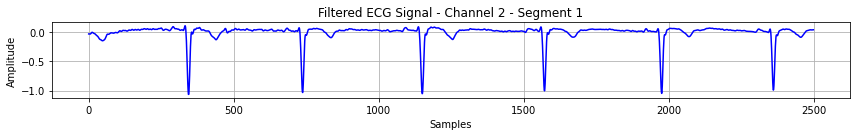

In [9]:
# Plotting the segmented blocks
def plot_segments(segments, title):
    num_segments = segments.shape[0]
    plt.figure(figsize=(12, 2 * num_segments))
    
    for i in range(num_segments):
        plt.subplot(num_segments, 1, i + 1)
        plt.plot(segments[i], color='blue')
        plt.title(f'{title} - Segment {i + 1}')
        plt.xlabel('Samples')
        plt.ylabel('Amplitude')
        plt.grid()
    
    plt.tight_layout()
    plt.show()

# Plot segmented blocks for filtered signal 1
plot_segments(segmented_signal1, 'Filtered ECG Signal - Channel 1')

# Plot segmented blocks for filtered signal 2
plot_segments(segmented_signal2, 'Filtered ECG Signal - Channel 2')


In [10]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the segmented signals
scaler = MinMaxScaler()

# Reshape for scaling (required for MinMaxScaler)
segmented_signal1_normalized = scaler.fit_transform(segmented_signal1.reshape(-1, 1)).reshape(segmented_signal1.shape)
segmented_signal2_normalized = scaler.fit_transform(segmented_signal2.reshape(-1, 1)).reshape(segmented_signal2.shape)


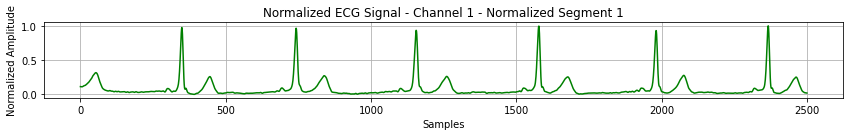

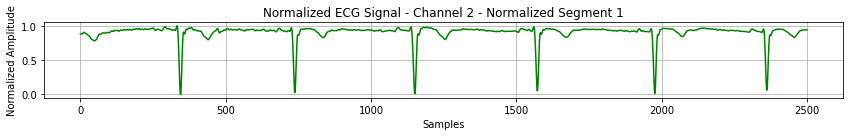

In [11]:
# Plotting the normalized segments
def plot_normalized_segments(segments, title):
    num_segments = segments.shape[0]
    plt.figure(figsize=(12, 2 * num_segments))
    
    for i in range(num_segments):
        plt.subplot(num_segments, 1, i + 1)
        plt.plot(segments[i], color='green')
        plt.title(f'{title} - Normalized Segment {i + 1}')
        plt.xlabel('Samples')
        plt.ylabel('Normalized Amplitude')
        plt.grid()
    
    plt.tight_layout()
    plt.show()

# Plot normalized segments for normalized signal 1
plot_normalized_segments(segmented_signal1_normalized, 'Normalized ECG Signal - Channel 1')

# Plot normalized segments for normalized signal 2
plot_normalized_segments(segmented_signal2_normalized, 'Normalized ECG Signal - Channel 2')


In [12]:
from scipy.signal import find_peaks

def extract_rr_intervals(ecg_signal, sampling_rate):
    # Find R-peaks
    peaks, _ = find_peaks(ecg_signal, height=0.5)  # Adjust height threshold as needed
    rr_intervals = np.diff(peaks) / sampling_rate  # Convert sample indices to seconds
    return rr_intervals

# Example usage
rr_intervals = extract_rr_intervals(filtered_signal1, sampling_rate)
print(f"R-R Intervals: {rr_intervals}")


R-R Intervals: [1.09166667 1.14722222 1.17222222 1.11944444 1.07222222 1.08611111
 1.14166667 1.17222222]


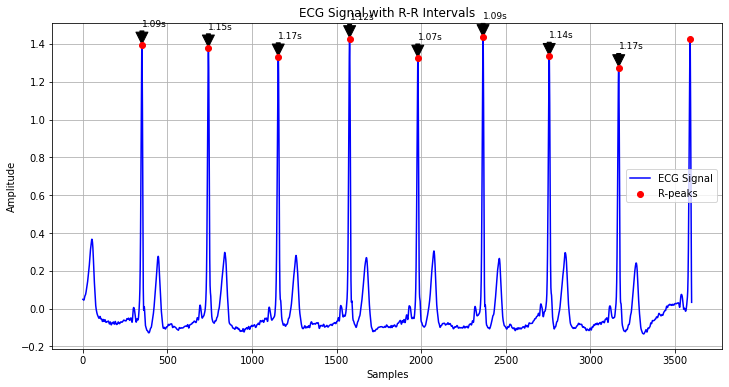

In [13]:
import matplotlib.pyplot as plt

def plot_ecg_with_rr_intervals(ecg_signal, rr_intervals, sampling_rate):
    # Find R-peaks
    peaks, _ = find_peaks(ecg_signal, height=0.5)  # Adjust height threshold as needed
    
    plt.figure(figsize=(12, 6))
    plt.plot(ecg_signal, label='ECG Signal', color='blue')
    plt.scatter(peaks, ecg_signal[peaks], color='red', label='R-peaks', zorder=5)
    
    # Annotate R-R intervals
    for i in range(1, len(peaks)):
        plt.annotate(f'{rr_intervals[i-1]:.2f}s', 
                     xy=(peaks[i-1], ecg_signal[peaks[i-1]]), 
                     xytext=(peaks[i-1], ecg_signal[peaks[i-1]] + 0.1),
                     arrowprops=dict(facecolor='black', shrink=0.05),
                     fontsize=9)
    
    plt.title('ECG Signal with R-R Intervals')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
# Assuming `filtered_signal1` is your ECG signal and `sampling_rate` is defined
rr_intervals = extract_rr_intervals(filtered_signal1, sampling_rate)  # Extract R-R intervals
plot_ecg_with_rr_intervals(filtered_signal1, rr_intervals, sampling_rate)


In [14]:
import numpy as np

def calculate_heart_rate(rr_intervals):
    # Convert R-R intervals from seconds to minutes
    heart_rate = 60 / np.mean(rr_intervals)
    return heart_rate

# Example: Assuming you have R-R intervals in seconds
# rr_intervals = [0.8, 0.9, 1.0, 0.85]  # Example R-R intervals
heart_rate = calculate_heart_rate(rr_intervals)
print(f"Heart Rate: {heart_rate} bpm")


Heart Rate: 53.3168775069423 bpm


In [15]:
pip install PyWavelets


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import pywt

def extract_wavelet_features(ecg_signal):
    coefficients = pywt.wavedec(ecg_signal, 'db4', level=5)  # Daubechies wavelet
    return coefficients

# Example usage
wavelet_features = extract_wavelet_features(filtered_signal1)
print(f"Wavelet Coefficients: {wavelet_features}")


Wavelet Coefficients: [array([ 0.26826945,  0.26793085,  0.26755576,  0.26669691,  0.29130944,
        0.14544564,  1.66115451,  0.62180103, -0.27574474, -0.37846167,
       -0.42759919, -0.44620883, -0.37325693, -0.3129509 , -0.69335224,
        1.38987222,  1.47738629, -0.83931859,  0.53598421,  0.56994316,
       -0.53015454, -0.48583065, -0.59078172, -0.57711647, -0.53030237,
       -0.50468154, -0.18118432, -0.12399574,  2.92402535, -0.34077756,
        0.19091796,  1.26297624, -0.31192207, -0.57548909, -0.65647519,
       -0.607191  , -0.54451035, -0.4677739 , -0.40384587, -0.34195324,
        0.35634443,  2.54296725, -0.44473057, -0.20698485,  1.28532256,
       -0.13332894, -0.56656915, -0.46249907, -0.46609249, -0.51521271,
       -0.52082814, -0.54572369, -0.06319567, -0.47202048,  3.07944424,
       -0.31667021, -0.1429826 ,  1.27404005, -0.25040404, -0.61617212,
       -0.55126219, -0.53796126, -0.54817184, -0.42983086, -0.35281127,
       -0.62623959,  1.49370496,  1.46880

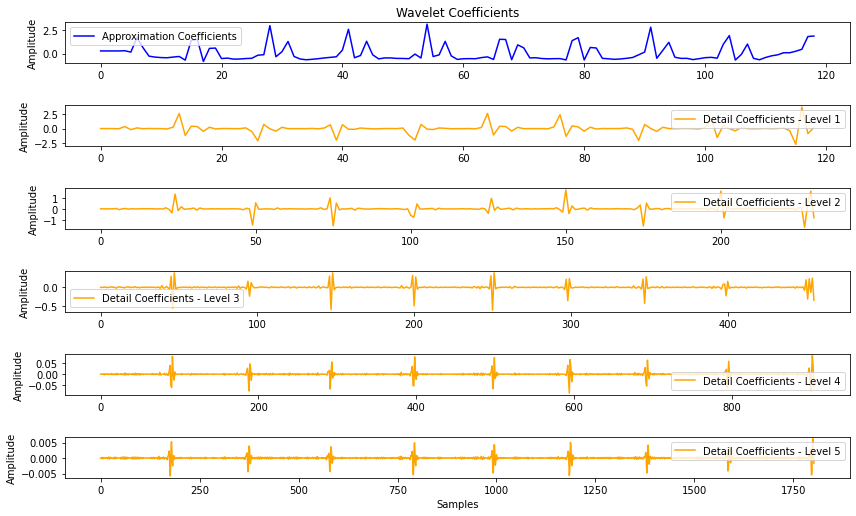

In [17]:
import matplotlib.pyplot as plt

def plot_wavelet_coefficients(coefficients):
    plt.figure(figsize=(12, 8))
    
    # Plot approximation coefficients
    plt.subplot(len(coefficients) + 1, 1, 1)
    plt.plot(coefficients[0], label='Approximation Coefficients', color='blue')
    plt.title('Wavelet Coefficients')
    plt.ylabel('Amplitude')
    plt.legend()
    
    # Plot detail coefficients
    for i in range(1, len(coefficients)):
        plt.subplot(len(coefficients) + 1, 1, i + 1)
        plt.plot(coefficients[i], label=f'Detail Coefficients - Level {i}', color='orange')
        plt.ylabel('Amplitude')
        plt.legend()
    
    plt.xlabel('Samples')
    plt.tight_layout()
    plt.show()

# Example usage
wavelet_features = extract_wavelet_features(filtered_signal1)
plot_wavelet_coefficients(wavelet_features)


Detected R-peaks: [ 349  742 1155 1577 1980 2366 2757 3168 3590]


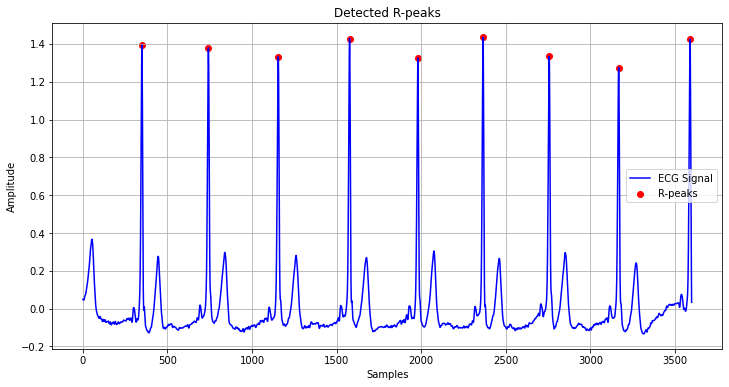

Analyzing segment from 369 to 409: [-0.08265975 -0.08964909 -0.0936893  -0.09652949 -0.09941094 -0.10277677
 -0.10641363 -0.10982559 -0.11258287 -0.11449432 -0.11561394 -0.11618033
 -0.11655772 -0.11716439 -0.1183436  -0.12019665 -0.12248898 -0.12474168
 -0.12649173 -0.12754684 -0.12803357 -0.1281951  -0.12810682 -0.12755075
 -0.126153   -0.12366863 -0.12019105 -0.11614634 -0.11211193 -0.10860705
 -0.10596611 -0.10429315 -0.1034346  -0.10295325 -0.1021711  -0.10035571
 -0.09701746 -0.09215178 -0.08624325 -0.07999515]
Analyzing segment from 762 to 802: [-0.0416042  -0.04912409 -0.05438643 -0.05859195 -0.06235517 -0.06573928
 -0.06852375 -0.07051442 -0.0717523  -0.0725478  -0.07333726 -0.07443324
 -0.07580391 -0.07702597 -0.07747308 -0.07665632 -0.07452116 -0.07151656
 -0.06839492 -0.06587578 -0.0643772  -0.06393235 -0.06425598 -0.06485
 -0.06509509 -0.0643743  -0.06228201 -0.05885959 -0.05468576 -0.05067934
 -0.04765697 -0.04588517 -0.04490463 -0.04374385 -0.04139981 -0.03731545
 -0.031

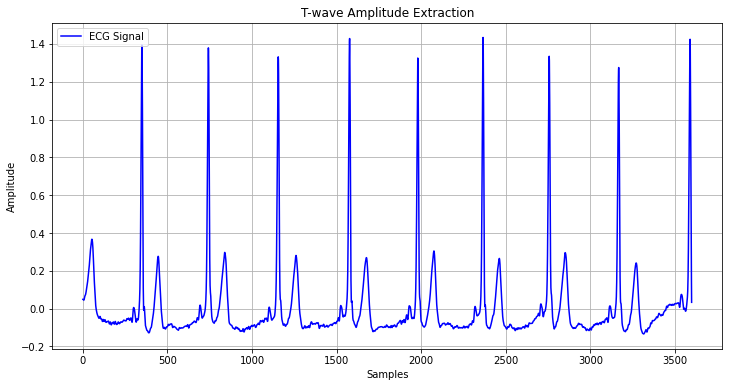

T-wave Amplitudes: []


In [18]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

def extract_t_wave_amplitude(ecg_signal, r_peaks):
    t_wave_amplitudes = []
    t_wave_indices = []

    # Prepare the plot
    plt.figure(figsize=(12, 6))
    plt.plot(ecg_signal, label='ECG Signal', color='blue')

    for r_peak in r_peaks:
        # Define a window to search for the T-wave (after the R-peak)
        start = r_peak + 20  # Adjust based on sampling rate and expected T-wave duration
        end = r_peak + 60    # Adjust based on sampling rate and expected T-wave duration
        
        if end < len(ecg_signal):
            # Extract the segment to analyze for T-wave
            segment = ecg_signal[start:end]
            print(f"Analyzing segment from {start} to {end}: {segment}")  # Debugging line
            
            # Find the T-wave peak in the defined window
            t_peaks, _ = find_peaks(segment, height=0.1)  # Adjust height threshold as needed
            
            if len(t_peaks) > 0:
                # Get the index of the T-wave peak relative to the original signal
                t_wave_index = t_peaks[0] + start
                t_wave_amplitude = ecg_signal[t_wave_index]
                t_wave_amplitudes.append(t_wave_amplitude)
                t_wave_indices.append(t_wave_index)

                # Plot the R-peak and T-wave
                plt.scatter(r_peak, ecg_signal[r_peak], color='red', label='R-peak' if r_peak == r_peaks[0] else "")
                plt.scatter(t_wave_index, t_wave_amplitude, color='green', label='T-wave Peak' if t_wave_index == t_wave_indices[0] else "")
    
    plt.title('T-wave Amplitude Extraction')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()

    return t_wave_amplitudes

# Example usage
# Assuming `filtered_signal1` is your ECG signal
r_peaks, _ = find_peaks(filtered_signal1, height=0.5)  # Detect R-peaks
print(f"Detected R-peaks: {r_peaks}")  # Debugging step

# Visualize R-peaks
plt.figure(figsize=(12, 6))
plt.plot(filtered_signal1, label='ECG Signal', color='blue')
plt.scatter(r_peaks, filtered_signal1[r_peaks], color='red', label='R-peaks')
plt.title('Detected R-peaks')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

# Extract T-wave amplitudes
t_wave_amplitudes = extract_t_wave_amplitude(filtered_signal1, r_peaks)
print(f"T-wave Amplitudes: {t_wave_amplitudes}")


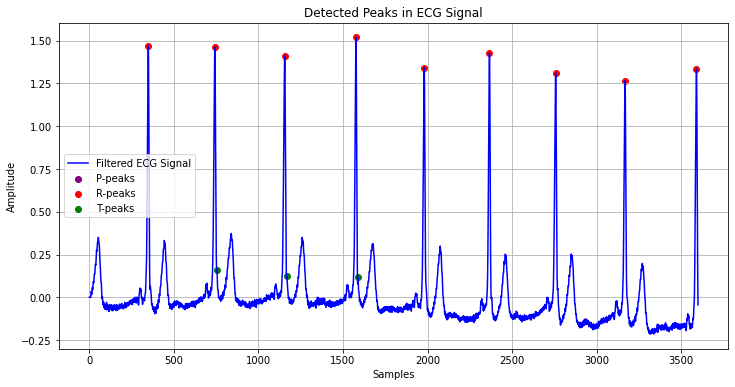

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def detect_peaks(ecg_signal, fs):
    # Preprocess the ECG signal
    filtered_signal = lowpass_filter(ecg_signal, cutoff=50, fs=fs)  # Adjust cutoff frequency as needed

    # Detect R-peaks (QRS complex)
    r_peaks, _ = find_peaks(filtered_signal, height=0.5, distance=fs*0.6)  # Minimum distance between peaks

    # Detect P-waves (before R-peaks)
    p_peaks = []
    for r in r_peaks:
        if r > 60:  # Ensure there's room to look for P-wave
            p_peak, _ = find_peaks(filtered_signal[r-60:r-20], height=0.1)  # Adjust the window
            if len(p_peak) > 0:
                p_peaks.append(p_peak[0] + r - 60)

    # Detect T-waves (after R-peaks)
    t_peaks = []
    for r in r_peaks:
        t_peak, _ = find_peaks(filtered_signal[r:r+60], height=0.1)  # Adjust the window
        if len(t_peak) > 0:
            t_peaks.append(t_peak[0] + r)

    return p_peaks, r_peaks, t_peaks, filtered_signal

# Example usage
fs = 250  # Sampling frequency in Hz
# Assuming `ecg_signal` is your raw ECG signal
p_peaks, r_peaks, t_peaks, filtered_signal = detect_peaks(signal1, fs)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(filtered_signal, label='Filtered ECG Signal', color='blue')
plt.scatter(p_peaks, filtered_signal[p_peaks], color='purple', label='P-peaks')
plt.scatter(r_peaks, filtered_signal[r_peaks], color='red', label='R-peaks')
plt.scatter(t_peaks, filtered_signal[t_peaks], color='green', label='T-peaks')
plt.title('Detected Peaks in ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()


C:\Users\ACER\AppData\Roaming\Python\Python310\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


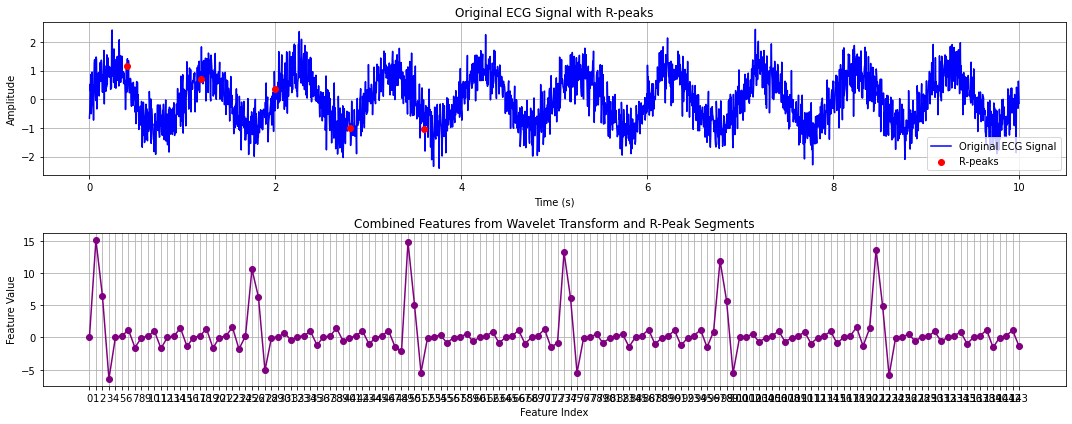

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Example ECG signal (replace with your actual ECG data)
fs = 250  # Sampling frequency
duration = 10  # seconds
num_samples = fs * duration  # Total samples
ecg_signal = np.sin(2 * np.pi * 1 * np.linspace(0, duration, num_samples)) + 0.5 * np.random.randn(num_samples)  # Simulated noisy ECG signal

# Simulated R-peaks (for demonstration purposes)
r_peaks = [100, 300, 500, 700, 900]  # Example R-peak indices

# Wavelet transform function
def wavelet_transform(ecg_signal):
    coeffs = pywt.wavedec(ecg_signal, 'db4', level=5)
    return coeffs

# Extracting wavelet features
def extract_wavelet_features(coeffs):
    features = []
    for coeff in coeffs:
        features.append(np.mean(coeff))
        features.append(np.var(coeff))
        features.append(np.max(coeff))
        features.append(np.min(coeff))
    return np.array(features)

# Extract segments around R-peaks
def extract_segments(ecg_signal, r_peaks, window_size=100):
    segments = []
    for r in r_peaks:
        start = max(r - window_size, 0)
        end = min(r + window_size, len(ecg_signal))
        segments.append(ecg_signal[start:end])
    return np.array(segments)

# Combine features
def combine_features(ecg_signal, r_peaks):
    wavelet_coeffs = wavelet_transform(ecg_signal)
    wavelet_features = extract_wavelet_features(wavelet_coeffs)
    
    segments = extract_segments(ecg_signal, r_peaks)
    segment_features = []
    for segment in segments:
        segment_wavelet_coeffs = wavelet_transform(segment)
        segment_wavelet_features = extract_wavelet_features(segment_wavelet_coeffs)
        segment_features.append(segment_wavelet_features)
    
    combined_features = np.hstack((wavelet_features, np.array(segment_features).flatten()))
    return combined_features

# Get combined features
combined_features = combine_features(ecg_signal, r_peaks)

# Create a time array that matches the length of the ECG signal
t = np.linspace(0, duration, num_samples)

# Plotting the original signal and combined features
plt.figure(figsize=(15, 6))

# Plot Original ECG Signal
plt.subplot(2, 1, 1)
plt.plot(t, ecg_signal, label='Original ECG Signal', color='blue')
plt.scatter(np.array(r_peaks)/fs, ecg_signal[r_peaks], color='red', label='R-peaks', zorder=5)
plt.title('Original ECG Signal with R-peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

# Plot Combined Features
plt.subplot(2, 1, 2)
plt.plot(combined_features, marker='o', linestyle='-', color='purple')
plt.title('Combined Features from Wavelet Transform and R-Peak Segments')
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.xticks(range(len(combined_features)))  # Show all feature indices
plt.grid()

plt.tight_layout()
plt.show()
